<a href="https://colab.research.google.com/github/Jean-Christ1/Deep-Learning-with-Keras-and-Tensorflow/blob/master/carvana_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Carvana Image Masking Challenge (kaggle) with tensorflow 2.0


<table class="tfo-notebook-buttons" align="left"><td>
<a target="_blank"  href="https://colab.research.google.com/github/csaybar/Carvana_kaggle/blob/master/carvana_kaggle.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>  
</td><td>
<a target="_blank"  href="https://github.com/csaybar/Carvana_kaggle/blob/master/carvana_kaggle.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td></table>

## Description:
As with any big purchase, full information and transparency are key. While most everyone describes buying a used car as frustrating, it’s just as annoying to sell one, especially online. Shoppers want to know everything about the car but they must rely on often blurry pictures and little information, keeping used car sales a largely inefficient, local industry.

Carvana, a successful online used car startup, has seen opportunity to build long term trust with consumers and streamline the online buying process.

An interesting part of their innovation is a custom rotating photo studio that automatically captures and processes 16 standard images of each vehicle in their inventory. While Carvana takes high quality photos, bright reflections and cars with similar colors as the background cause automation errors, which requires a skilled photo editor to change.
<center>
<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3333/media/carvana_graphics.png" />
 </center>

In this competition, you’re challenged to develop an algorithm that automatically removes the photo studio background. This will allow Carvana to superimpose cars on a variety of backgrounds. You’ll be analyzing a dataset of photos, covering different vehicles with a wide variety of year, make, and model combinations.

The dataset of this competition contains a large number of car images, with each car taken from different angles. In addition, for each car image, we have an associated manually cutout mask; our task will be to automatically create these cutout masks for unseen data.



## 1. My Workflow

1. Visualize data/perform some exploratory data analysis
2. Set up data pipeline and preprocessing (ImageDataGenerator)
3. Build model
4. Train model
5. Evaluate model
6. Repeat


In [ ]:
!pip install kaggle
!pip install tensorflow==2.0.0-alpha0

In [ ]:
import os
import glob
import zipfile
import functools

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing import image as img

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models
from tensorflow.keras import backend as K


mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

## 2. Get all the files
- **Only import kaggle after adding the credentials.**
- **You must [accept the competition rules](https://www.kaggle.com/c/carvana-image-masking-challenge/rules) before downloading the data.**


Since this tutorial will be using a dataset from Kaggle, it requires [creating an API Token](https://github.com/Kaggle/kaggle-api#api-credentials) for your Kaggle account, and uploading it.

In [ ]:
import os

# Upload the API token.
def get_kaggle_credentials():
  token_dir = os.path.join(os.path.expanduser("~"),".kaggle")
  token_file = os.path.join(token_dir, "kaggle.json")
  if not os.path.isdir(token_dir):
    os.mkdir(token_dir)
  try:
    with open(token_file,'r') as f:
      pass
  except IOError as no_file:
    try:
      from google.colab import files
    except ImportError:
      raise no_file

    uploaded = files.upload()

    if "kaggle.json" not in uploaded:
      raise ValueError("You need an API key! see: "
                       "https://github.com/Kaggle/kaggle-api#api-credentials")
    with open(token_file, "wb") as f:
      f.write(uploaded["kaggle.json"])
    os.chmod(token_file, 600)

get_kaggle_credentials()

Only import kaggle after adding the credentials.

In [ ]:
import kaggle

In [ ]:
competition_name = 'carvana-image-masking-challenge'

### 2.1 Define competition
Caution, large download ahead - downloading all files will require 14GB of diskspace.

In [ ]:

# Download data from Kaggle and unzip the files of interest. # Downl
def load_data_from_zip(competition, file):
  with zipfile.ZipFile(os.path.join(competition, file), "r") as zip_ref:
    unzipped_file = zip_ref.namelist()[0]
    zip_ref.extractall(competition)

def get_data(competition):
    kaggle.api.competition_download_files(competition, competition)
    load_data_from_zip(competition, 'train.zip')
    load_data_from_zip(competition, 'train_masks.zip')
    load_data_from_zip(competition, 'train_masks.csv.zip')


In [ ]:
get_data(competition_name)

### 2.1 Wrangling data time!
Create a training/test dataset

In [ ]:
# getting the folder paths
img_dir = os.path.join(competition_name, "train")
label_dir = os.path.join(competition_name, "train_masks")

In [ ]:
# Reading the csv file with the images basenames.
df_train = pd.read_csv(os.path.join(competition_name, 'train_masks.csv'))
ids_train = df_train['img'].map(lambda s: s.split('.')[0])

In [ ]:
x_train_filenames = []
y_train_filenames = []
for img_id in ids_train:
  x_train_filenames.append(os.path.join(img_dir, "{}.jpg".format(img_id)))
  y_train_filenames.append(os.path.join(label_dir, "{}_mask.gif".format(img_id)))

In [ ]:
# Split randomly the images using sklearn
x_train_filenames, x_val_filenames, y_train_filenames, y_val_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2, random_state=42)

In [ ]:
num_train_examples = len(x_train_filenames)
num_val_examples = len(x_val_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of validation examples: {}".format(num_val_examples))

Number of training examples: 4070
Number of validation examples: 1018


# Visualize
Let's take a look at some of the examples of different images in our dataset.

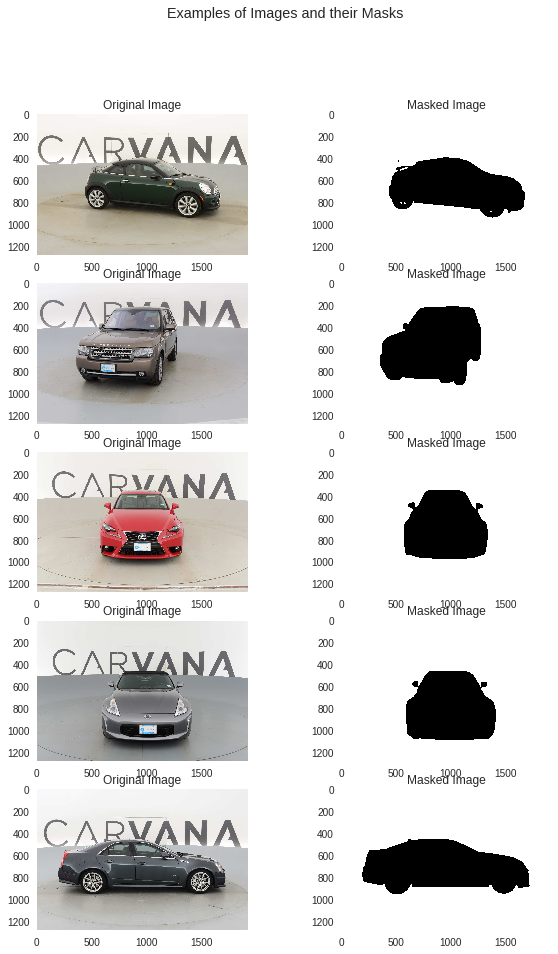

In [ ]:
display_num = 5

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
  img_num = r_choices[i // 2]
  x_pathname = x_train_filenames[img_num]
  y_pathname = y_train_filenames[img_num]

  plt.subplot(display_num, 2, i + 1)
  plt.imshow(mpimg.imread(x_pathname))
  plt.title("Original Image")

  example_labels = Image.open(y_pathname)
  label_vals = np.unique(example_labels)

  plt.subplot(display_num, 2, i + 2)
  plt.imshow(example_labels)
  plt.title("Masked Image")

plt.suptitle("Examples of Images and their Masks")
plt.show()

## Setup

Let’s begin by setting up some parameters. We’ll standardize and resize all the shapes of the images. We’ll also set up some training parameters:

In [ ]:
img_shape = (256, 256, 3)
batch_size = 3
epochs = 5

Using these exact same parameters may be too computationally intensive for your hardware, so tweak the parameters accordingly. Also, it is important to note that due to the architecture of our UNet version, the size of the image must be evenly divisible by a factor of 32, as we down sample the spatial resolution by a factor of 2 with each `MaxPooling2Dlayer`.


If your machine can support it, you will achieve better performance using a higher resolution input image (e.g. 512 by 512) as this will allow more precise localization and less loss of information during encoding. In addition, you can also make the model deeper.


Alternatively, if your machine cannot support it, lower the image resolution and/or batch size. Note that lowering the image resolution will decrease performance and lowering batch size will increase training time.


In [ ]:
from tensorflow.keras.preprocessing import image as pretf_img
from tensorflow.keras import layers

## Processing each pathname

Use `tf.io.read_file`  to convert  the pathname to a  binary-string and `tf.image.decode_jpeg` to a tensor.

In [ ]:
def _process_pathnames(fname, label_path):
  # We map this function onto each pathname pair
  img_str = tf.io.read_file(fname)
  image = tf.image.decode_jpeg(img_str, channels=3)

  label_img_str = tf.io.read_file(label_path)
  # These are gif images so they return as (num_frames, h, w, c)
  label_img = tf.image.decode_gif(label_img_str)[0]
  # The label image should only have values of 1 or 0, indicating pixel wise
  # object (car) or not (background). We take the first channel only.
  label_img = label_img[:, :, 0]
  target = tf.expand_dims(label_img, axis=-1)
  return image, target

## ImageDataGenerator for semantic segmentation

In [ ]:
import warnings

class ImageDataGenerator:
  def __init__(self,
               dataset = None,
               len_image = None,
               resize={'image':True, 'target':True, 'resize':[256,256]},
               s_vs_p={'image':True, 'target':False, 'amount':[0.001, 0.01], 'salt_vs_pepper':[0.1, 0.4]},
               gauss_noise = {'image':True, 'target': False,'gn_stddev':[0.5,1]},
               translate = {'apply':True,'width_tr':0,'height_tr':0},
               flip = {'apply':True,'horizontal':True,'vertical':True},
               scale = {'apply':True, 'scaling':0.70},
               rotation = {'apply':True,'just_degree_90':True},
               transpose = {'apply':True},
               color = {'apply':True, 'hue_apply':True,'hue_max_delta':0.08,'saturation_apply':True, 'saturation_range':[0.6, 1.6],
                        'brightness_apply':True, 'brightness_delta':0.05,'contrast_apply':True, 'contrast_range':[0.7, 1.3]},
               image_scale=1/255.,
               target_scale=1/255.,
               threads = 2,
               batch_size=3,
               shuffle=True
               ):

    #Dataset
    self.dataset = dataset

    # Hyperparameters
    self.image_scale = image_scale
    self.target_scale = target_scale
    self.threads = threads
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.len_image = len_image
    #Methods parameters
    self.resize = resize
    self.s_vs_p = s_vs_p
    self.gauss_noise = gauss_noise
    self.translate = translate
    self.flip = flip
    self.scale = scale
    self.rotation = rotation
    self.transpose = transpose
    self.color = color

  @staticmethod
  def _number_random_generator(il_range):
    amount = tf.random_uniform([], il_range[0],il_range[1])
    return amount


  @staticmethod
  def create_random_sparse_matrix(image, n_pix):
    total_pixels = tf.reduce_prod(image)
    z_pixels = total_pixels - n_pix

    zero_value = tf.zeros(z_pixels)
    one_value = tf.ones(n_pix)
    merge_val = tf.concat([zero_value, one_value],axis = 0)
    shufl_val = tf.random.shuffle(merge_val)

    matrix_sparse = tf.reshape(shufl_val,image)
    exp_mat = tf.expand_dims(matrix_sparse,-1)
    mtx_3d = tf.tile(exp_mat,[1,1,3])
    return  mtx_3d


  @staticmethod
  def img_resize(image,resize):
    image = tf.image.resize(image, resize)
    return image

  def salt_pepper_noise(self, image, amount, salt_vs_pepper):
    tensor_dims = tf.shape(image)

    im_dims = tensor_dims[:2]
    pixel_num = tf.reduce_prod(im_dims)
    num_salt = tf.to_int32(tf.ceil(amount * tf.to_float(pixel_num) * salt_vs_pepper))
    num_pepper = tf.to_int32(tf.ceil(amount * tf.to_float(pixel_num) * (1.0 - salt_vs_pepper)))

    # Add salt noise
    sparsePixels = self.create_random_sparse_matrix(im_dims,num_salt)
    neg_sparsePixels = 1. - sparsePixels
    image_batch = image*neg_sparsePixels + sparsePixels

    # Add pepper noise
    sparsePixels = self.create_random_sparse_matrix(im_dims,num_pepper)
    neg_sparsePixels = 1. - sparsePixels
    image_batch = image_batch*neg_sparsePixels
    return image_batch

  def gaussNoise_image(self, image, gn_stddev):
    noise = tf.truncated_normal(tf.shape(image), mean=0.5, stddev = gn_stddev, dtype=tf.float32)
    noise = tf.clip_by_value(noise, 0.0, 1.0)
    image = 0.75*image + 0.25*noise
    return image

  def image_translate(self, image, target, img_size):
    width_shift_range = self._number_random_generator([self.translate['width_tr']*-1*img_size[1], self.translate['width_tr']*img_size[1]])
    height_shift_range = self._number_random_generator([self.translate['height_tr']*-1*img_size[0], self.translate['height_tr']*img_size[0]])
    image = tfcontrib.image.translate(image, [width_shift_range, height_shift_range])
    target = tfcontrib.image.translate(target, [width_shift_range, height_shift_range])
    return image, target

  def image_target_size(self, image, target):
    image_size = image.get_shape().as_list()[:2]
    target_size = target.get_shape().as_list()[:2]
    return image_size, target_size

  def flip_image(self, image, target):
    if self.flip['horizontal']:
      flip_prob = tf.random_uniform([], 0.0, 1.0)
      image = tf.cond(tf.less(flip_prob, 0.5),
                      lambda: tf.image.flip_left_right(image),
                      lambda: image)
      target = tf.cond(tf.less(flip_prob, 0.5),
                       lambda: tf.image.flip_left_right(target),
                       lambda: target)
    if self.flip['vertical']:
      flip_prob = tf.random_uniform([], 0.0, 1.0)
      image = tf.cond(tf.less(flip_prob, 0.5),
                      lambda: tf.image.flip_up_down(image),
                      lambda: image)
      target = tf.cond(tf.less(flip_prob, 0.5),
                       lambda: tf.image.flip_up_down(target),
                       lambda: target)
    return image, target

  def scaling_image(self, image, target, image_size):

    if self.scale['apply']:
      scale = np.random.uniform(self.scale['scaling'], 1)
    x1 = y1 = (1 - scale) * 0.5
    x2 = y2 = (1 + scale) * 0.5

    boxes = np.array([[y1, x1, y2, x2]], dtype = np.float32)

    box_ind = np.zeros(1, dtype = np.int32)
    crop_size = np.array([image_size[0], image_size[1]], dtype = np.int32)

    image = tf.expand_dims(image,axis = 0)
    target = tf.expand_dims(target,axis = 0)

    tf_img = tf.image.crop_and_resize(image, boxes, box_ind, crop_size)
    tf_target = tf.image.crop_and_resize(target, boxes, box_ind, crop_size)

    tf_target = tf.squeeze(tf_target,axis = 0)
    tf_img = tf.squeeze(tf_img,axis = 0)
    return tf_img, tf_target

  def rotate_image(self, image, target):
    if  self.rotation['just_degree_90']:
      K = np.random.randint(0,3)
      tf_img = tf.image.rot90(image, K)
      tf_target = tf.image.rot90(target, K)
      return tf_img, tf_target
    else:
      angle_rot = tf.random_uniform([], 0, 100) * 3.141516 / 180
      tf_img = tf.contrib.image.rotate(image, angle_rot)
      tf_target = tf.contrib.image.rotate(target, angle_rot)
      return tf_img, tf_target

  def transpose_image(self, image, target):
    tf_img = tf.image.transpose_image(image)
    tf_target = tf.image.transpose_image(target)
    return tf_img, tf_target

  def image_random_color(self, image):
    if self.color['hue_apply']:
      image = tf.image.random_hue(image, self.color['hue_max_delta'])
    if self.color['saturation_apply']:
      lower = self.color['saturation_range'][0]
      upper = self.color['saturation_range'][1]
      image = tf.image.random_saturation(image, lower, upper)
    if self.color['brightness_apply']:
      image = tf.image.random_brightness(image, self.color['brightness_delta'])
    if self.color['contrast_apply']:
      lower = self.color['contrast_range'][0]
      upper = self.color['contrast_range'][1]
      image = tf.image.random_contrast(image, lower, upper)
      return image


  def _augment(self,image,target):

    # 1. Apply scale to image and target
    target = tf.cast(target, tf.float32) * self.image_scale
    image = tf.cast(image, tf.float32) * self.target_scale

    # 2. Resize image
    if self.resize['target'] is True and self.resize['image'] is False:
      target = self.img_resize(target, self.resize['resize'])
      warnings.warn('Some image augmentation methods will not be available if the "image" and "target" do not have the same resolution.')

    elif self.resize['target'] is False and self.resize['image'] is True:
      image = self.img_resize(image, self.resize['resize'])
      warnings.warn('Some image augmentation methods will not be available if the "image" and "target" do not have the same resolution.')

    elif self.resize['target'] is True and self.resize['image'] is True:
      image = self.img_resize(image, self.resize['resize'])
      target = self.img_resize(target, self.resize['resize'])

    else:
      print('"image" and "target" was not resized')


    # 3. Salt and pepper noise
    if self.s_vs_p['target'] is True and self.s_vs_p['image'] is False:
      # parameterstranspose_image
      amount = self._number_random_generator(self.s_vs_p['amount'])
      salt_vs_pepper = self._number_random_generator(self.s_vs_p['salt_vs_pepper'])
      # algorithm
      target = self.salt_pepper_noise(target, amount, salt_vs_pepper)

    elif self.s_vs_p['target'] is False and self.s_vs_p['image'] is True:
      # parameters
      amount = self._number_random_generator(self.s_vs_p['amount'])
      salt_vs_pepper = self._number_random_generator(self.s_vs_p['salt_vs_pepper'])
      # algorithm
      image = self.salt_pepper_noise(image, amount, salt_vs_pepper)

    elif self.s_vs_p['target'] is True and self.s_vs_p['image'] is True:
      # parameters
      amount = self._number_random_generator(self.s_vs_p['amount'])
      salt_vs_pepper = self._number_random_generator(self.s_vs_p['salt_vs_pepper'])
      # algorithm
      image = self.salt_pepper_noise(image, amount, salt_vs_pepper)
      target = self.salt_pepper_noise(target, amount, salt_vs_pepper)


    # 4. Gaussian noise
    if self.gauss_noise['target'] is True and self.gauss_noise['image'] is False:
      # parameters
      gn_stddev = self._number_random_generator(self.gauss_noise['gn_stddev'])
      target = self.gaussNoise_image(target, gn_stddev)

    elif self.gauss_noise['target'] is False and self.gauss_noise['image'] is True:
      # parameters
      gn_stddev = self._number_random_generator(self.gauss_noise['gn_stddev'])
      # algorithm
      image = self.gaussNoise_image(image, gn_stddev)

    elif self.gauss_noise['target'] is True and self.gauss_noise['image'] is True:
      # parameters
      gn_stddev = self._number_random_generator(self.gauss_noise['gn_stddev'])

      # algorithm
      image = self.gaussNoise_image(image, gn_stddev)
      target = self.gaussNoise_image(target, gn_stddev)

    # 5.  Translate
    if self.translate['apply']:
      image_size, target_size = self.image_target_size(image, target)
      assert image_size == target_size, print('Image and Target must be have the same spatial resolution')
      image, target = self.image_translate(image, target, image_size)


    # 6. Flip
    if self.flip['apply']:
      image, target = self.flip_image(image, target)

    # 7. Scale
    if self.scale['apply']:
      image_size, target_size = self.image_target_size(image, target)
      assert image_size == target_size, print('Image and Target must be have the same spatial resolution')
      image, target = self.scaling_image(image,target,image_size)

    # 8. Rotate
    if self.rotation['apply']:
      image, target = self.rotate_image(image, target)

    # 9. Transpose
    if self.transpose['apply']:
      image, target = self.transpose_image(image, target)

    # 10. Color
    if self.color['apply']:
      image = self.image_random_color(image)
    return image, target

  def get_dataset(self):
    self.dataset = self.dataset.map(self._augment, num_parallel_calls = self.threads)
    if self.shuffle:
      self.dataset = self.dataset.shuffle(self.len_image)
    self.dataset = self.dataset.repeat().batch(self.batch_size)
    return self.dataset

### Apply  `_process_pathnamest` to the dataset

In [ ]:
def get_baseline_dataset(filenames,
                         labels,
                         threads=2):
  # Create a dataset from the filenames and labels
  dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
  dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)
  return dataset

## 5. Set up train and validation datasets
Note that we apply image augmentation to our training dataset but not our validation dataset.

In [ ]:
translate = {'apply':False, 'width_tr':0.2, 'height_tr':0.2}
resize = {'image':True, 'target':True, 'resize':[128,128]}
flip = {'apply':False,'horizontal':True,'vertical':True}
scale = {'apply':False, 'scaling':0.85}
transpose = {'apply':False}
rotation = {'apply':False,'just_degree_90':False}
s_vs_p={'image':False, 'target':False, 'amount':[0.001, 0.01], 'salt_vs_pepper':[0.1, 0.4]}
gauss_noise = {'image':False, 'target': False,'gn_stddev':[0.5,1]}
color = {'apply':False, 'hue_apply':False,'hue_max_delta':0.08,'saturation_apply':False, 'saturation_range':[0.6, 1.6],
         'brightness_apply':False, 'brightness_delta':0.05,'contrast_apply':False, 'contrast_range':[0.7, 1.3]}

In [ ]:
len_image_train = len(x_train_filenames)
len_image_test = len(x_val_filenames)

#Train dataset
dataset_train = get_baseline_dataset(x_train_filenames,y_train_filenames)
datagen_train = ImageDataGenerator(dataset = dataset_train,len_image = len_image_train,resize = resize, translate = translate,flip = flip,scale = scale,rotation = rotation,gauss_noise = gauss_noise, s_vs_p = s_vs_p,transpose = transpose, shuffle = False)
train_ds = datagen_train.get_dataset()

#Test dataset
dataset_test = get_baseline_dataset(x_val_filenames, y_val_filenames)
datagen_test = ImageDataGenerator(dataset = dataset_test, len_image = len_image_test, resize = resize, translate = translate,flip = flip,scale = scale,rotation = rotation,gauss_noise = gauss_noise, s_vs_p = s_vs_p,transpose = transpose, shuffle = False)
test_ds = datagen_test.get_dataset()

# Build the model
We'll build the U-Net model. U-Net is especially good with segmentation tasks because it can localize well to provide high resolution segmentation masks. In addition, it works well with small datasets and is relatively robust against overfitting as the training data is in terms of the number of patches within an image, which is much larger than the number of training images itself. Unlike the original model, we will add batch normalization to each of our blocks.

The Unet is built with an encoder portion and a decoder portion. The encoder portion is composed of a linear stack of [`Conv`](https://developers.google.com/machine-learning/glossary/#convolution), `BatchNorm`, and [`Relu`](https://developers.google.com/machine-learning/glossary/#ReLU) operations followed by a [`MaxPool`](https://developers.google.com/machine-learning/glossary/#pooling). Each `MaxPool` will reduce the spatial resolution of our feature map by a factor of 2. We keep track of the outputs of each block as we feed these high resolution feature maps with the decoder portion. The Decoder portion is comprised of UpSampling2D, Conv, BatchNorm, and Relus. Note that we concatenate the feature map of the same size on the decoder side. Finally, we add a final Conv operation that performs a convolution along the channels for each individual pixel (kernel size of (1, 1)) that outputs our final segmentation mask in grayscale.


In [ ]:
def conv_block(input_tensor, num_filters):
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  return encoder

def encoder_block(input_tensor, num_filters):
  encoder = conv_block(input_tensor, num_filters)
  encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)

  return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
  decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
  decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  return decoder

In [ ]:
from tensorflow.keras import layers

In [ ]:
inputs = layers.Input(shape=img_shape)
# 256

encoder0_pool, encoder0 = encoder_block(inputs, 32)
# 128

encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
# 64

encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
# 32

encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
# 16

encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)
# 8

center = conv_block(encoder4_pool, 1024)
# center

decoder4 = decoder_block(center, encoder4, 512)
# 16

decoder3 = decoder_block(decoder4, encoder3, 256)
# 32

decoder2 = decoder_block(decoder3, encoder2, 128)
# 64

decoder1 = decoder_block(decoder2, encoder1, 64)
# 128

decoder0 = decoder_block(decoder1, encoder0, 32)
# 256

outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

## Define your model
Using functional API, you must define your model by specifying the inputs and outputs associated with the model.

In [ ]:
model = models.Model(inputs=[inputs], outputs=[outputs])

## Defining custom metrics and loss functions
Defining loss and metric functions are simple with Keras. Simply define a function that takes both the True labels for a given example and the Predicted labels for the same given example.

Dice loss is a metric that measures overlap. More info on optimizing for Dice coefficient (our dice loss) can be found in the [paper](http://campar.in.tum.de/pub/milletari2016Vnet/milletari2016Vnet.pdf), where it was introduced.

We use dice loss here because it performs better at class imbalanced problems by design. In addition, maximizing the dice coefficient and IoU metrics are the actual objectives and goals of our segmentation task. Using cross entropy is more of a proxy which is easier to maximize. Instead, we maximize our objective directly.

In [ ]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

In [ ]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [ ]:
def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

## Compile your model
We use our custom loss function to minimize. In addition, we specify what metrics we want to keep track of as we train. Note that metrics are not actually used during the training process to tune the parameters, but are instead used to measure performance of the training process.

In [ ]:
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_loss])
#model.summary()
#tf.keras.utils.plot_model(model)

In [ ]:
save_model_path = '/tmp/weights.hdf5'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_dice_loss', save_best_only=True, verbose=1)

In [ ]:
history = model.fit(train_ds,
                   steps_per_epoch=int(np.ceil(num_train_examples / float(batch_size))),
                   epochs=epochs,
                   validation_data=val_ds,
                   validation_steps=int(np.ceil(num_val_examples / float(batch_size))),
                   callbacks=[cp])

1357